## Temperature experiment allele counts by filtering method
---
We are going to first count the number of multiallelic sites within unique plants, then within groups of plants.

[Dan Koboldt's 2012 comment on the `readcounts` utility](https://sourceforge.net/p/varscan/discussion/1073559/thread/c647b0ba/#2acb)

Load necessary package(s) and temperature experiment data:

In [1]:

data = pd.read_csv("variant-calls_temperature-expt_2020-04-07_tables.csv",
                   header=0,
                   index_col=0)

C:\Users\Erik\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<div class="alert alert-block alert-warning">
<b>Note:</b> The above warning stems from incomplete data in rows from the 32$^{o}$ data, which we will remove.
</div>

In [2]:
#remove 32 degree data
data = data.loc[data.temperature != 32]

#fix the data types for the two problemmatic columns
data.directVegParent = data.directVegParent.astype(str)
data.DP = data.DP.astype(int)

Define a function to return a dictionary of counts of sites with $X$ alleles 

In [3]:
def get_allele_counts(data):
    #initialize variables to hold working data
    running_allele_counts = []
    count_data = {}
    
    #count alleles per site by unique plant ID
    for plant in data.plantID.unique():
        plant_data =  data.loc[data.plantID == plant]
        for position in plant_data.pos.unique():
            running_allele_counts.append(plant_data.loc[plant_data.pos == position].shape[0])
    
    #count the number of sites with i _alternate_ alleles;
    #add 1 to dictionary index to represent _total_ alleles per site
    for i in range(1,max(running_allele_counts)+1):        
        count_data[i+1] = running_allele_counts.count(i)
        
    #return the dictionary    
    return count_data

def print_counts(data):
    
    #print the allele counts nicely
    print("Alleles/site\t# Observed")
    for count in data.keys():
        print("{}\t\t{}".format(count,data[count]))
    return

In [4]:
raw_allele_counts = get_allele_counts(data)

In [5]:
print_counts(raw_allele_counts)

Alleles/site	# Observed
2		14483
3		8799
4		5083
5		2336
6		750
7		165
8		17
9		1


Remove the alleles with no representation in one technical replicate: 

In [6]:
no_na_data = data.dropna(subset=['DPReplicateA','DPReplicateB'])

In [7]:
no_na_counts = get_allele_counts(no_na_data)

In [8]:
print_counts(no_na_counts)

Alleles/site	# Observed
2		15008
3		5056
4		1258
5		120


#### Filter alleles by minimum 3% in at least one technical replicate, and present in the other

In [9]:
min_3percent = pd.merge(no_na_data.loc[no_na_data.freqPropReplicateA >= 0.03],
                        no_na_data.loc[no_na_data.freqPropReplicateB >= 0.03],
                        how='outer')

min_3percent.drop_duplicates(inplace=True)
min_3percent_allele_counts = get_allele_counts(min_3percent)
print_counts(min_3percent_allele_counts)

Alleles/site	# Observed
2		1158
3		12


Let's look at how minimum frequency cutoff affects max allele count per site

In [10]:
def min_snp_freq_data(data, minimum=0.01, freq1='freqPropReplicateA', freq2='freqPropReplicateB'):
    
    temp = pd.merge(data.loc[data[freq1] >= minimum],data.loc[data[freq2] >= minimum],how='outer')
    return temp

In [11]:
x = [i/1000 for i in range(0,31)]
y = [max(get_allele_counts(min_snp_freq_data(no_na_data,j))) for j in x]

Text(0.5, 1.0, 'Alleles represented in both tech reps')

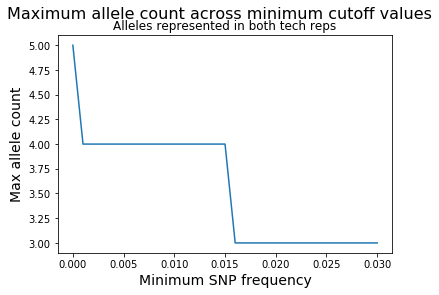

In [12]:
plt.plot(x,y)
plt.xlabel("Minimum SNP frequency",fontsize=14)
plt.ylabel("Max allele count",fontsize=14)
plt.suptitle("Maximum allele count across minimum cutoff values",fontsize=16)
plt.title("Alleles represented in both tech reps")

In [13]:
x_r = [i/1000 for i in range(0,31)]
y_r = [max(get_allele_counts(min_snp_freq_data(data,j))) for j in x_r]

Text(0.5, 1.0, 'Alleles represented in either tech rep')

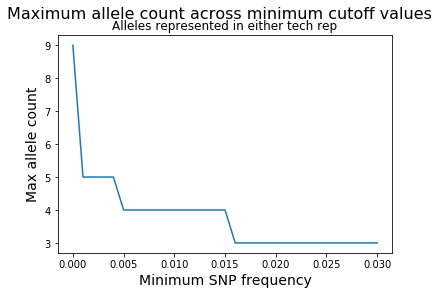

In [14]:
plt.plot(x_r,y_r)
plt.xlabel("Minimum SNP frequency",fontsize=14)
plt.ylabel("Max allele count",fontsize=14)
plt.suptitle("Maximum allele count across minimum cutoff values",fontsize=16)
plt.title("Alleles represented in either tech rep")

#### Calculate a mean frequency between technical replicates and filter alleles by minimum 3% of the mean
First, use raw data and fill NA's with zeros then filter by minimum 3% average

In [15]:
#fill the NAs of the frequency columns with zeros
data.freqPropReplicateA.fillna(0)
data.freqPropReplicateB.fillna(0)

#generate an average frequency proportion column (simple)
data['meanFreqProp'] = data[['freqPropReplicateA','freqPropReplicateB']].mean(axis=1)

#count the sites with X alleles
mean_3percent = data.loc[data.meanFreqProp >= 0.03]
mean_3percent_allele_counts = get_allele_counts(mean_3percent)
print_counts(mean_3percent_allele_counts)

Alleles/site	# Observed
2		1110
3		12


#### Calculate a mean frequency between technical replicates after having dropped alleles with no representation in one technical replicate

In [16]:
#generate an average frequency proportion column (must be present in both tech reps)
no_na_data.meanFreqProp = no_na_data[['freqPropReplicateA','freqPropReplicateB']].mean(axis=1)

#count the sites with X alleles
mean_3percent_no_na = no_na_data.loc[no_na_data.meanFreqProp >= 0.03]
mean_3percent_no_na_allele_counts = get_allele_counts(mean_3percent_no_na)
print_counts(mean_3percent_no_na_allele_counts)

C:\Users\Erik\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Alleles/site	# Observed
2		1090
3		12


(*to do*)
### Now let's count alleles by groups of plants
Maintain separation of species and segment, but group by round, temperature, etc.

In [17]:
#raw data, no 32 degree samples
acmv_a = data.loc[data.chrom == 'ACMV DNA-A']
acmv_b = data.loc[data.chrom == 'ACMV DNA-B']
eacmcv_a = data.loc[data.chrom == 'EACMCV DNA-A']
eacmcv_b = data.loc[data.chrom == 'EACMCV DNA-B']

#NAs dropped
acmv_a_no_na = no_na_data.loc[no_na_data.chrom == 'ACMV DNA-A']
acmv_b_no_na = no_na_data.loc[no_na_data.chrom == 'ACMV DNA-B']
eacmcv_a_no_na_data = no_na_data.loc[no_na_data.chrom == 'EACMCV DNA-A']
eacmcv_b_no_na_data = no_na_data.loc[no_na_data.chrom == 'EACMCV DNA-B']
